# CIFAR-10 Image Classification

The CIFAR-10 dataset is a good starting point for your deep learning journey, this notebook is written to help beginners learn how to train a ConvNet using PyTorch for image classification on the CIFAR-10 dataset. It goes through the details about how to write a custom dataset class, the model and the trainer class.

### Importing Packages
Start by importing all the necessary packages. They are imported separately because the jupyter notebook kernel dies sometimes when we import all the packages at once.

In [2]:
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image 

In [3]:
import torch

In [4]:
import torch.nn as nn

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter

In [6]:
import torch.nn.functional as F
import torch.optim as optim

In [7]:
from torchvision.utils import make_grid

### Downloading and Understanding the Data

Before we begin writing the dataset class, it is important to understand the structure and format of the dataset. First, download the CIFAR-10 dataset from the [CIFAR-10 website.](https://www.cs.toronto.edu/~kriz/cifar.html) The dataset contains 60,000 images and corresponding labels, the dataset is divided into a train-set with 50,000 images and a test-set with 10,000 images. They are all stored as pickle files, the website also provides a handy function to extract them. 


In [8]:
#extract pickle files as specified in the CIFAR-10 website
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

The above function returns a dictionary from the pickle file. The train batches are named - `data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5`. The test batch is named - `test_batch`. Let's understand more about these data batches and group them into a single batch to analyse. 

In [9]:
#group all batches 
train_data = [] 
for files in os.listdir("./cifar-10-batches-py"):
    if "data_batch" in files:
        train_data.append(unpickle(os.path.join('./cifar-10-batches-py', files)))

In [10]:
len(train_data)

5

We know that `unpickle` function returned a dictionary, let's explore what the keys are and prepare the train set with images and labels.

In [11]:
train_data[0].keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [12]:
train_set_X = []
for batch in train_data:
    train_set_X.append(batch[b'data'])

In [13]:
train_set_y = []
for batch in train_data:
    train_set_y.append(batch[b'labels'])

In [14]:
np.array(train_set_X).shape

(5, 10000, 3072)

In [15]:
np.array(train_set_y).shape

(5, 10000)

### Reshaping and Preparing the Train-Test Splits

The `shape` attribute shown above gives us the dimensions of the nd-array or the nd-tensor. So the value of `(5, 10000, 3072)` for the shape of `train_set_X` tells us that there are 5 batches, each of which contains `10000` rows and each of those rows is an array of length `3072`. It is an image that contains `3` channels and has a height and width of `32`, flattening this gives us the array with `3072` values. Hence, each row is an image stored as an array. 

We will stack these data batches vertically to obtain the full training set of 50,000 images. 

In [16]:
train_set_X = np.vstack(train_set_X)
train_set_X.shape

(50000, 3072)

An image is usually represented as an array of dimension `(H, W, C)` wheras a mini batch is usually represented as an array of dimension `(N, C, H, W)` where N stands for batch size, C for the number of channels, H for the height and W for width of the image. We will apply this reshaping to the train-set. As mentioned in the [CIFAR-10 website,](https://www.cs.toronto.edu/~kriz/cifar.html) the first `1024` values in each row represent the red channel, the next `1024` represent the green channel and the last `1024` represent the blue channel. Hence, we reshape the training set such that the image will have the dimension `3, 32, 32`. The `-1` tells the `reshape` method to figure out the dimension based on the other values in the tuple. 

Note : When writing a dataloader which reads image from the png or jpeg format, the dimension will be `(H, W, C)` and to convert to `(C, H, W)` we generally use the `ToTensor()` transform. It also scales the values between 0 and 1. Since we already have the image data in cifar-10 with dimension `(C, H, W)`, we only have to apply the scaling, hence we divide the image tensor by 255. 

In [17]:
train_set_X = train_set_X.reshape(-1, 3, 32, 32) / 255
train_set_X.shape

(50000, 3, 32, 32)

Similarly explore the testing set. 

In [18]:
test_data = unpickle('./cifar-10-batches-py/test_batch')

In [19]:
test_data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [20]:
test_set_X = test_data[b'data']
test_set_X = test_set_X.reshape(-1, 3, 32, 32) / 255
np.array(test_set_X).shape

(10000, 3, 32, 32)

In [21]:
test_set_y = test_data[b'labels']
np.array(test_set_y).shape

(10000,)

### Writing a Custom Dataset Class

Let's use the knowledge gained from exploring the dataset to create a dataset class. When working with PyTorch, we usually write a custom dataset class which inherits the `Dataset` class from the `torch.utils.data` package, we will then pass it to the powerful `Dataloader` class provided by PyTorch. We will be creating a map style dataset which implements the `__len__` and `__getitem__` protocols. It is like telling the `Dataloader` how to fetch one sample and it will provide us with a batch of data while training which will be loaded onto the GPU. This is necessary because it will be impossible to fit large datasets in the GPU memory. Read more about the dataset class in the [official documentation](https://pytorch.org/docs/stable/data.html). 

`__init__` : Responsible for initialising the attributes that we might need, `root` represents the path of the dataset, `train` argument tells if it is a train split or not and the `transforms` attribute is used to perform data augmentation using transformations like `RandomRotation`, `ColorJitter` and `RandomHorizontalFlip`. We also extract the training and testing data depending on the split, reshape them and store them in `self.data` and `self.targets`. 

`__len__` : Protocol to be implemented for map style datasets, returns the length of the training set.

`__getitem__` : Protocol responsible for fetching a sample from the dataset based on the index. It will be used by the `Dataloader` for fetching a batch of samples. We read the image and target from the attributes we created during the `__init__` method, apply the required transforms and return them. 


In [22]:
class CIFAR10(Dataset):
    
    def __init__(self, root, train = True, transforms = None):
        self.root = root
        self.transforms = transforms
        self.train = train
        self.data = []
        self.targets = []
        self.train_data = [file for file in os.listdir(root) if "data_batch" in file]
        self.test_data = [file for file in os.listdir(root) if "test_batch" in file]
        
        data_split = self.train_data if self.train else self.test_data
        
        for files in data_split:
            extract = self.unpickle(os.path.join(root, files))
            self.data.append(extract[b'data'])
            self.targets.extend(extract[b'labels'])
            
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.load_meta()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, target = self.data[index], self.targets[index]
        if self.transforms:
            image = self.transforms(image)
        return torch.tensor(image, dtype = torch.float32) / 255, target
    
    def load_meta(self):
        path = os.path.join(self.root, "batches.meta")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding = "latin1")
            self.classes = data["label_names"]
            self.classes_to_idx = {_class:i for i, _class in enumerate(self.classes)}
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    

    def plot(self, image, target = None):
        if target is not None:
            print(f"Target :{target}, Class :{self.classes[target]}")
        plt.figure(figsize = (2,2))
        #to convert from (3, 32, 32) to (32, 32, 3)
        image = torch.tensor(image.numpy().transpose(1,2,0) * 255, dtype = torch.int32)
        plt.imshow(image)
        plt.show()

In [23]:
train_set = CIFAR10(root = "./cifar-10-batches-py", train = True)
test_set = CIFAR10(root = "./cifar-10-batches-py", train = False)

### Visualizing Batch Images

Visualizing what goes into your model is very essential. It is at this stage that you will find certain pre-processing errors that may have happened but you didn't know that it had occured. Looks like our dataset class and the dataloader class work perfectly without any bugs. 

Target :2, Class :bird


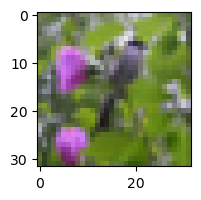

In [24]:
batch = train_set[300]
img, label = batch
train_set.plot(img, label)

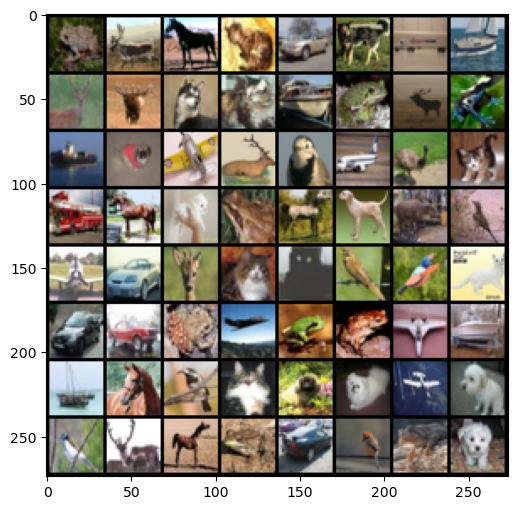

In [25]:
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
batch = iter(train_loader)
images, labels = next(batch)
grid = make_grid(images, nrow = 8)
plt.figure(figsize = (6, 6))
plt.imshow(grid.permute(1,2,0))
plt.show()

### Building the ConvNet Model

We will write a simple medium sized convolutional neural network using the `torch.nn` module and the `torch.nn.functional` API. We will define the layers in the `__init__` method of the `ConvNet` class and write the code for forward propagation in the `forward` method. Unlike in Tensorflow, where we specify the number of filters, the `torch.nn.Conv2d` method requires us to specify `in_channels` for the number of input channels and `out_channels` for the number of output channels. You can also implement the depthwise convolution by using the `groups` argument, learn more about `torch.nn.Conv2d` in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). The input spatial dimension is `(32, 32)`, the output spatial dimension will remain `(32, 32)` because of using `kernel_size = (3, 3), padding = 1, stride = 1` for the conv layers. However, we have used `nn.MaxPool2d` in between the conv layers 2 times, with `kernel_size = (2, 2), stride = 2` which will essentially reduce the spatial dimensions by half, each time. Hence, before the first fully connected layer `fc1`, the volume will be of spatial dimension `(8, 8)` and there will be 256 channels, this is the reason for using `in_features = 8 * 8 * 256` in the `fc1` layer. The last output layer gets the `10` unnormalized class scores, often known as logits and then we use `cross_entropy` loss function which takes the `logits` and the `targets`.

In [26]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3), padding = 1, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = (3, 3), padding = 1, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = 1, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = 1, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = 1, stride = 1)
        
        self.fc1 = nn.Linear(in_features = 8 * 8 * 256, out_features = 256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 64)
        self.fc4 = nn.Linear(in_features = 64, out_features = 10)
        
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.dropout = nn.Dropout2d(p = 0.5)
        
    def forward(self, x, targets):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1, 8 * 8 * 256)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        logits = self.fc4(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss

### The Training Configuration Class

It is possible to pass hyperparameters and other arguments directly and train the model, however, a nice and clean way is to have all the configuration settings in one place. Hence the `TrainingConfig` class, which will be passed as an object to the training loop.

In [27]:
class TrainingConfig:
    
    lr = 0.0003
    betas = (0.9, 0.995)
    weight_decay = 5e-4
    steps = 100
    eval_step = 10
    batch_size = 64
    shuffle = True
    pin_memory = True
    resume = True
    model_dir = './cifar10.pk'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

### The Training Loop

The training loop takes in the `net, train_loader, test_loader, optim, config` objects. We will write the training loop in such a way that we will be able to resume training from where we stopped it. We track the losses and the accuracies in `train_losses, test_losses, train_accuracies, test_accuracies` arrays. The training loop first checks the `config.resume` and `config.model_dir` to see if we have to resume training and then obtains the losses, accuracies etc, if the model is not present, training will happen from scratch. 

It the runs a loop for `config.steps`, in each step, we obtain a batch of `images, targets` and send them to a cuda device if there is one, run forward propagation - `net(images, targets)`, calculate the loss, accuracy and then perform backward propagation. Backpropagation consists of three steps, computing the gradients with respect to the parameters, performing an update, clearing the gradients. This is done using the code - `loss.backward(); optim.step(); optim.zero_grad()`.

For every `config.eval_step` number of epochs, we test the model, and if the accuracy is better than the best model so far, we save it using `torch.save`. We use `model.eval()` and `torch.set_grad_enabled(False)` during testing as we need not compute gradients. 

Note : `model.train()` tells your model that you are training it. This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. Similarly, we use `model.eval()` during inference.

In [28]:
def train(net, train_loader, test_loader, optim, config):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    max_accuracy = 0
    start_step = 0

    if config.resume and os.path.exists(config.model_dir):
        print(f'resume from {config.model_dir}')
        ckp = torch.load(config.model_dir, map_location = config.device)
        train_losses = ckp['train_losses']
        train_accuracies = ckp['train_accuracies']
        test_accuracies = ckp['test_accuracies']
        net.load_state_dict(ckp['model'])
        start_step = ckp['step']
        max_accuracy = ckp['max_accuracy']
        print(f'Training from step {start_step} :\n' )
    else :
        print('Training from scratch :\n')

    for step in range(start_step + 1, config.steps + 1):
        start = time.time()
        correct = 0
        accuracy = 0
        num_samples = 0 
        lr = config.lr
        
        net.train()
        images, targets = next(iter(train_loader))
        images = images.to(config.device); targets = targets.to(config.device)
        num_samples = targets.size(0)
        logits, loss = net(images, targets)
        loss = loss.mean()
        predictions = torch.argmax(logits, dim = 1) 
        correct += predictions.eq(targets).sum().item()
        accuracy = correct / num_samples
        train_accuracies.append(accuracy)
        train_losses.append(loss.item())
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        print(f'\rTrain loss : {loss.item():.5f} | Step : {step}/{config.steps} | Training accuracy : {accuracy :.7f} | Time taken : {(time.time() - start) : .2f}', end = '', flush = True)
        
        if step % config.eval_step == 0 :
            with torch.no_grad():
                test_accuracy, test_loss = test(net, test_loader, config)

            print(f'\nTest loss : {test_loss:.5f} | Testing accuracy : {test_accuracy:.7f} ')
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
            
            if test_accuracy > max_accuracy :
                max_accuracy = test_accuracy
                torch.save({
                            'step':step,
                            'max_accuracy':max_accuracy,
                            'train_losses':train_losses,
                            'test_losses':test_losses,
                            'train_accuracies':train_accuracies,
                            'test_accuracies':test_accuracies,
                            'model':net.state_dict()
                }, config.model_dir)
                print(f'Model saved at step :{step} | Max accuracy:{max_accuracy:.5f}\n')

In [29]:
def test(net, test_loader, config):
    correct = 0
    num_samples = 0
    losses = []
    accuracies = []
    loss = 0
    accuracy = 0
    
    net.eval()
    torch.cuda.empty_cache()
    
    for i, (images, targets) in enumerate(test_loader):
        images = images.to(config.device); targets = targets.to(config.device)
        num_samples += targets.size(0)
        with torch.set_grad_enabled(False):
            logits, loss = net(images, targets)
            loss = loss.mean()
            losses.append(loss.item())
        predictions = torch.argmax(logits, dim = 1) 
        correct += predictions.eq(targets).sum().item()
        accuracy = correct / num_samples
        accuracies.append(accuracy)
        
    return np.mean(accuracies), np.mean(losses)

### Training and Hyperparameter Optimization

Finally, when we train the model, we need to choose a sufficiently small learning rate. If `lr` is too high, it may lead to unpredictable results during training. A good default is `lr = 3e-4`, feel free to play around with this before selecting a final learning rate for training. We also create the `net`, `train_loader`, `test_loader` and `optimizer` instances to pass them to the training loop. The `batch_size` argument must be chosen depending on the GPU memory. It is advisable to start with `64` and increase till the size where the batch takes up just below the full capacity. A perfect combination of `batch_size` and `lr` should see the training loss decrease over time without erratic behaviour. 

In [38]:
config = TrainingConfig(lr = 3e-4, batch_size = 1024, steps = 21000, eval_step = 100, resume = True)
net = ConvNet()
net = net.to(config.device)
train_loader = DataLoader(train_set, batch_size = config.batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = config.batch_size, shuffle = False)
optimizer = optim.Adam(net.parameters(), lr = config.lr, betas = config.betas, weight_decay = config.weight_decay)

In [37]:
train(net, train_loader, test_loader, optimizer, config)

resume from ./cifar10.pk
Training from step 20800 :

Train loss : 0.20059 | Step : 20900/21000 | Training accuracy : 0.9375000 | Time taken :  0.15
Test loss : 1.67313 | Testing accuracy : 0.6401945 
Train loss : 0.32821 | Step : 21000/21000 | Training accuracy : 0.8906250 | Time taken :  0.16
Test loss : 1.66986 | Testing accuracy : 0.6379764 


### Plotting Graphs

In [40]:
trained_model = ConvNet()
checkpoint = torch.load(config.model_dir, config.device)
trained_model.load_state_dict(checkpoint['model']) 
step = checkpoint['step']
max_accuracy = checkpoint['max_accuracy']
print("Best epoch :", step)
print("Best testing accuracy :", max_accuracy.round(4))

Best epoch : 20800
Best testing accuracy : 0.6798


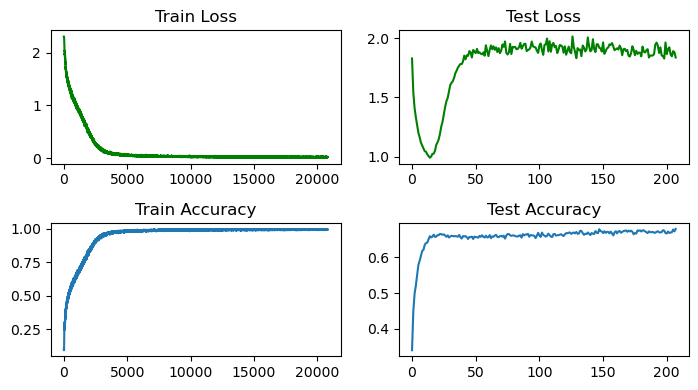

In [41]:
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True

figure, axis = plt.subplots(2, 2)
axis[0, 0].plot(checkpoint['train_losses'], 'g')
axis[0, 0].set_title("Train Loss")

axis[0, 1].plot(checkpoint['test_losses'], 'g')
axis[0, 1].set_title("Test Loss")

axis[1, 0].plot(checkpoint['train_accuracies'])
axis[1, 0].set_title("Train Accuracy")

axis[1, 1].plot(checkpoint['test_accuracies'])
axis[1, 1].set_title("Test Accuracy")
plt.show()